# Machine Learning Lab CS360
## Assignment 6

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from sklearn.utils import shuffle

In [2]:
warnings.filterwarnings('ignore')
np.random.seed(42)

In [3]:
def encode_one_hot(Y):
    labels = list()
    for y in Y:
        if y in labels:
            pass
        else:
            labels.append(y)
    labels.sort()
    k = len(labels)
    encoded_y = list()
    for y in Y:
        encoding = [1 if i == labels.index(y) else 0 for i in range(k)]
        encoded_y.append(encoding)
    encoded_y = np.array(encoded_y)
    encodings_to_labels = dict()
    for i, label in enumerate(labels):
        encodings_to_labels[str(i)] = label
    return encoded_y, encodings_to_labels

def split_data(X, y, split, seed=None):
    c = y.shape[1]
    X, y = shuffle(X, y, random_state=seed)
    cp = [1, 1, 1]
    split = split * y.shape[0] / c
    X_train, X_test, y_train, y_test = list(), list(), list(), list()
    for i, label in enumerate(y):
        if cp[label.argmax()] > split:
            X_test.append(X[i])
            y_test.append(label)
        else:
            X_train.append(X[i])
            y_train.append(label)
            cp[label.argmax()] += 1
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

def simulate(model_type):
    store = dict()
    
    for split in range(10, 70, 10):
        print(f"TRAIN/TEST Split: {split}/{100 - split}")
        
        split /= 100
        store[str(split)] = {
            'train_accuracy': list(),
            'test_accuracy': list()
        }
    
        print("\n") 
    
        for simulation in range(10):
            if model_type == "SLP":
                model = SLP(X_base.shape[1], y_base.shape[1])
            else:
                model = MLP(X_base.shape[1], 6, y_base.shape[1])
                
            seed = int(split*100+simulation)
            X_train, y_train, X_test, y_test = split_data(X_base, y_base, split, seed=seed)
            model.fit(X_train, y_train)
            train_acc = model.accuracy(X_train, y_train)
            store[str(split)]['train_accuracy'].append(train_acc*100)
            test_acc = model.accuracy(X_test, y_test)
            store[str(split)]['test_accuracy'].append(test_acc*100)
        
            print(f"Simulation {simulation+1}: Train Accuracy: {train_acc * 100: .2f}      Test Accuracy: {test_acc * 100: .2f}")
        
        print("")
    return store

def plot(store):
    train_avg, test_avg = list(), list()
    x_ax = list()
    
    for i in range(10, 70, 10):
        x_ax.append(i)
        i /= 100
        train_avg.append(np.mean(store[str(i)]['train_accuracy']))
        test_avg.append(np.mean(store[str(i)]['test_accuracy']))
        
    df = pd.DataFrame()
    df['Randomly Selected Training Data'] = x_ax
    df['Training Accuracy'] = train_avg
    df['Test Accuracy'] = test_avg
    
    print(df)
    
    figure = plt.figure(figsize=(14, 14))
    ax = figure.add_subplot(111, xlabel='Training Data in %', ylabel='Accuracy')
    ax.plot(x_ax, train_avg, marker='o', c='r', label='Training Accuracy')
    ax.plot(x_ax, test_avg, marker='o', c='g', label='Test Accuracy')
    leg = ax.legend(loc=2)

In [4]:
# SLP with Threshold Activation Function & One-vs-All approach for multi-class classification

class SLP():
  def __init__(self, input_feats, classes, learning_rate=1):
    self._weights = np.random.default_rng().standard_normal((input_feats+1, classes))
    self._classes = classes
    self._lr = learning_rate
    
  def predict(self, X):
    if X.shape[1] != self._weights.shape[0]:
        X = self.__add_bias(X)
    
    z = X @ self._weights
    return self.__activation(z)

  def __activation(self, z, train=False):
#     print(z.dtype)
#     a = 1 / (1 + np.exp(-z))
#     a = a / np.reshape(np.sum(a, axis=1), newshape=(-1, 1))
    if train:
        a = z
        a[z >= 0] = 1
        a[z < 0] = 0
    else:
        a = np.zeros(z.shape)
        a[z == np.reshape(z.max(axis=1), newshape=(-1, 1))]
    return z
    
  def __add_bias(self, array):
    X = np.c_[np.ones(array.shape[0]), array]
    return np.array(X, dtype='float64')

  def fit(self, X, Y, epochs=5000):
    X = self.__add_bias(X)
    for i in range(epochs):
        for i in range(X.shape[0]):
            x = X[i].reshape(1, -1)
            z = x @ self._weights
            y_hat = self.__activation(z, train=True)
            y = Y[i].reshape(1, -1)
            self._weights = self._weights + self._lr * x.T @ (y - y_hat)
        
  def accuracy(self, X, y):
    y_hat = self.predict(X).argmax(axis=1)
    y = y.argmax(axis=1)
    return (y == y_hat).mean()

In [11]:
# MLP with 1 hidden layer and Softmax Output Layer

class MLP():
    def __init__(self, input_feats, hidden_neurons, classes, learning_rate=1e-4):
        self._weights1 = np.random.default_rng().standard_normal((input_feats+1, hidden_neurons))
        self._weights2 = np.random.default_rng().standard_normal((hidden_neurons+1, classes))
        self._classes = classes
        self._lr = learning_rate
    
    def __add_bias(self, array):
        array = np.c_[np.ones(array.shape[0]), array]
        return np.array(array, dtype='float64')
    
    def __sigmoid_activation(self, array):
        return 1 / (1 + np.exp(-array))
    
    def __softmax_activation(self, array):
        z = np.exp(array)
        return z / np.sum(z, axis=1).reshape(-1, 1)
        
    def __loss_function(self, y_hat, y):
        return -np.sum(y * np.log(y_hat)).item() / y.shape[0]
    
    def __gradients(self, y_hat, y, h_actv, x):
        dw2 = y_hat - y
        dw2 = h_actv.T @ dw2
        dw2 = dw2 / y.shape[0]

        dw1 = x.T @ (y_hat - y) @ self._weights2[1:, :].T * h_actv.sum(axis=0).reshape(1, -1)[:, 1:]
        dw1 = dw1 / y.shape[0]

        return dw1, dw2
    
    def __forward_prop(self, X):
        h = self.__sigmoid_activation(X @ self._weights1)
        
        h = self.__add_bias(h)
        y_hat = self.__softmax_activation(h @ self._weights2)
        
        return y_hat, h
    
    def predict(self, X):
        X = self.__add_bias(X)
        y_pred, _ = self.__forward_prop(X)
        return y_pred
    
    def __backprop(self, y_hat, y, h, X):
        dw1, dw2 = self.__gradients(y_hat, y, h, X)
        self._weights1 = self._weights1 - self._lr * dw1
        self._weights2 = self._weights2 - self._lr * dw2
        
    def fit(self, X, y, epochs=500000):
        converged = lambda x, y: True if 1e-6 > x - y > -1e-6 else False
        X = self.__add_bias(X)
        history = []
        for i in range(epochs):
            y_hat, h = self.__forward_prop(X)
            loss = self.__loss_function(y_hat, y)
            history.append(loss)  
            self.__backprop(y_hat, y, h, X)
            try:
              if converged(history[-2], loss):
                break
            except IndexError:
              pass
            
        return history
    
    def accuracy(self, X, y):
        y_hat = self.predict(X)
        y_hat = y_hat.argmax(axis=1)
        y = y.argmax(axis=1)
        return (y == y_hat).sum() / X.shape[0]
        

In [6]:
dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", header=None)
dataset.head()

X_base = dataset.to_numpy()[:, 0:4]
y_base = dataset.to_numpy()[:, -1]
y_base, mappings = encode_one_hot(y_base) 

print(mappings)

del dataset

{'0': 'Iris-setosa', '1': 'Iris-versicolor', '2': 'Iris-virginica'}


### Implementation of Single Layer Perceptron

In [7]:
cache = simulate(model_type="SLP")

TRAIN/TEST Split: 10/90


Simulation 1: Train Accuracy:  100.00      Test Accuracy:  79.26
Simulation 2: Train Accuracy:  86.67      Test Accuracy:  77.78
Simulation 3: Train Accuracy:  66.67      Test Accuracy:  48.89
Simulation 4: Train Accuracy:  93.33      Test Accuracy:  76.30
Simulation 5: Train Accuracy:  100.00      Test Accuracy:  71.11
Simulation 6: Train Accuracy:  73.33      Test Accuracy:  71.85
Simulation 7: Train Accuracy:  100.00      Test Accuracy:  51.85
Simulation 8: Train Accuracy:  100.00      Test Accuracy:  77.78
Simulation 9: Train Accuracy:  86.67      Test Accuracy:  68.89
Simulation 10: Train Accuracy:  66.67      Test Accuracy:  65.93

TRAIN/TEST Split: 20/80


Simulation 1: Train Accuracy:  76.67      Test Accuracy:  70.83
Simulation 2: Train Accuracy:  90.00      Test Accuracy:  73.33
Simulation 3: Train Accuracy:  66.67      Test Accuracy:  70.83
Simulation 4: Train Accuracy:  63.33      Test Accuracy:  71.67
Simulation 5: Train Accuracy:  53.33      Test

   Randomly Selected Training Data  Training Accuracy  Test Accuracy
0                               10          87.333333      68.962963
1                               20          72.666667      70.000000
2                               30          79.111111      74.380952
3                               40          73.166667      72.888889
4                               50          73.733333      70.666667
5                               60          76.888889      77.000000


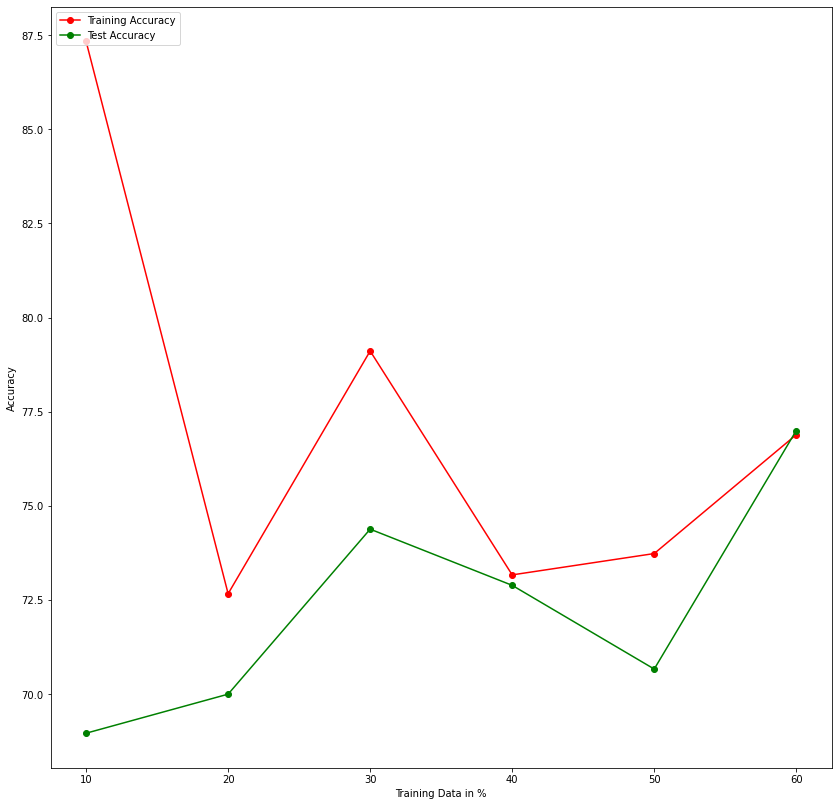

In [8]:
plot(cache)

### Implement Multi-Layer Perceptron

In [12]:
cache = simulate(model_type="MLP")

TRAIN/TEST Split: 10/90


Simulation 1: Train Accuracy:  33.33      Test Accuracy:  33.33
Simulation 2: Train Accuracy:  100.00      Test Accuracy:  88.15
Simulation 3: Train Accuracy:  66.67      Test Accuracy:  61.48
Simulation 4: Train Accuracy:  80.00      Test Accuracy:  69.63
Simulation 5: Train Accuracy:  100.00      Test Accuracy:  93.33
Simulation 6: Train Accuracy:  73.33      Test Accuracy:  69.63
Simulation 7: Train Accuracy:  66.67      Test Accuracy:  72.59
Simulation 8: Train Accuracy:  13.33      Test Accuracy:  4.44
Simulation 9: Train Accuracy:  86.67      Test Accuracy:  95.56
Simulation 10: Train Accuracy:  73.33      Test Accuracy:  68.89

TRAIN/TEST Split: 20/80


Simulation 1: Train Accuracy:  33.33      Test Accuracy:  33.33
Simulation 2: Train Accuracy:  66.67      Test Accuracy:  65.00
Simulation 3: Train Accuracy:  66.67      Test Accuracy:  60.00
Simulation 4: Train Accuracy:  70.00      Test Accuracy:  66.67
Simulation 5: Train Accuracy:  93.33      Test Ac

   Randomly Selected Training Data  Training Accuracy  Test Accuracy
0                               10          54.000000      56.740741
1                               20          54.333333      53.000000
2                               30          54.222222      53.142857
3                               40          55.333333      54.444444
4                               50          57.600000      58.933333
5                               60          46.666667      46.166667


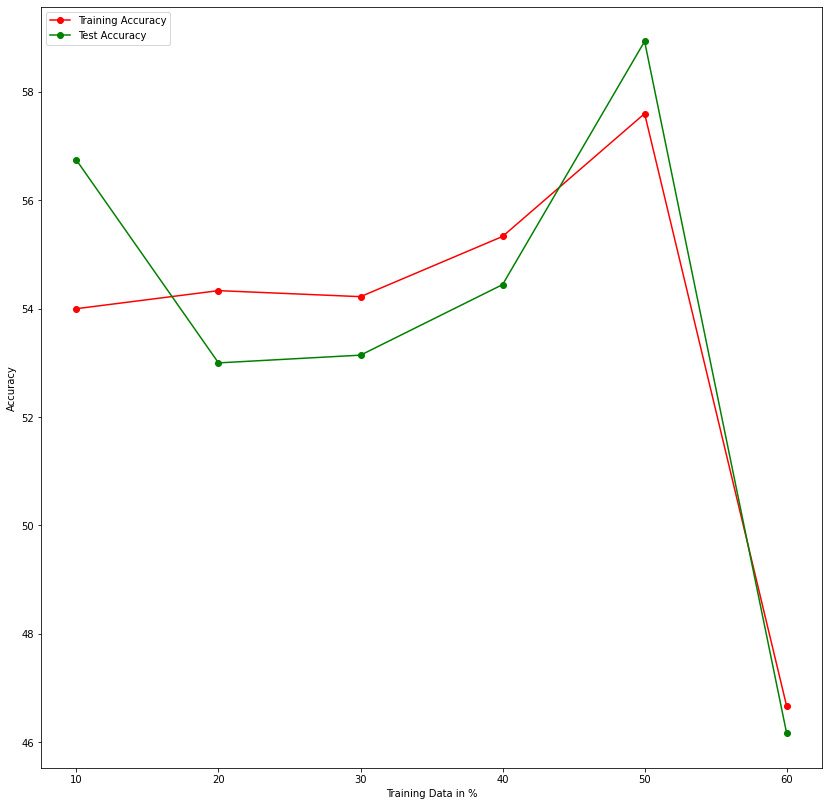

In [10]:
plot(cache)